In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2 as cv
from keras.utils import to_categorical
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
import sys
sys.path.append("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Functions")
from Functions import detectPose, extract_angles, moving_average

This should introduce the whole idea (I have already done this in my log on the 26/11/2024 date).

Load the GRU model that classifies every frame into the following classes:
- Class 0 = No Curl
- Class 1 = Concentric Contraction
- Class 2 = Eccentric Contraction

In [3]:
Model = load_model("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Classification\\Bicep Curl\\Detailed Exercise Classification\\Models\\Detailed_Exercise_Classification.h5")

In [117]:
# path = "C:\\Users\\Cian\\OneDrive\\Documents\\Imperial\\Year 4\\FYP\\Local Download\\Technical\\Bicep Curl Analysis\\Technique Modelling\\Training Data (Videos)\\Incorrect Technique (for validation)\\2.mp4"
# path = "C:\\Users\\Cian\\OneDrive\\Documents\\Imperial\\Year 4\\FYP\\Local Download\\Technical\\Bicep Curl Analysis\\Technique Modelling\\Training Data (Videos)\\Correct Technique\\4.mp4"
path = "C:\\Users\\Cian\\Downloads\\Incorrect.mp4"
Angles1 = extract_angles(path)

In [118]:
start = int(15*4)
end = int(15*37.55)
Angles = Angles1

# Data Processing and Prediction
Use the exact same code as used previously in the file called "GRU Training" to process the data and then use the imported model to make a prediction for each frame, then apply a moving average to these predictions. I have plotted graphs since this helps to decide on the required size of the window in the moving average (I am currently doing this manually, but I should eventually automate it with correlation analysis to individual frequency peaks).

In [119]:
window_size = 17
angles = np.copy(Angles)
angles[:,0], angles[:,1], angles[:,2] = moving_average(Angles[:,0], window_size), moving_average(Angles[:,1], window_size), moving_average(Angles[:,2], window_size)

In [120]:
dt = 1/15
ang_vel = (angles[2:,:]-angles[:-2,:])/(2*dt)
#normalize the angles (however think of a better way to do this)
ang_vel = ang_vel/np.max(ang_vel)

In [121]:
#Now moving average.
window_size1 = 9
Vel = np.copy(ang_vel)
Vel[:,0], Vel[:,1], Vel[:,2] = moving_average(ang_vel[:,0], window_size1), moving_average(ang_vel[:,1], window_size1), moving_average(ang_vel[:,2], window_size1)

In [122]:
ang = angles[1:-1]

(-1.0, 1.0)

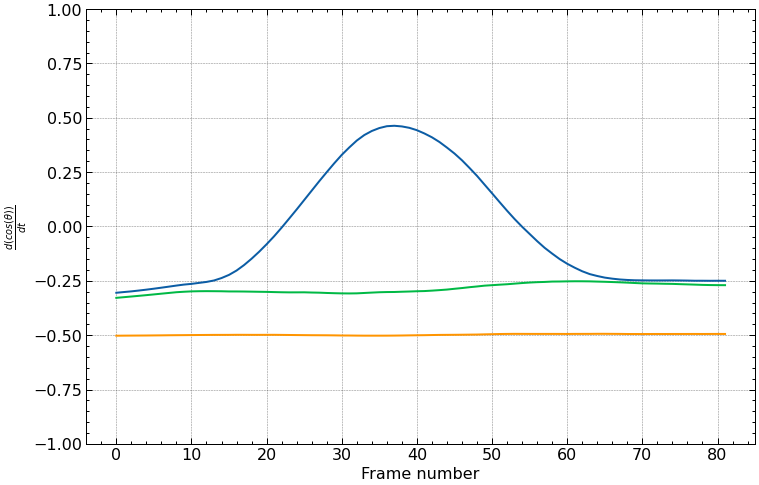

In [123]:
o = np.arange(0,len(ang),1)
plt.figure(figsize=(12,8))
plt.plot(o,ang[:,2])
plt.plot(o,ang[:,1])
plt.plot(o,ang[:,0])
plt.xlabel('Frame number')
plt.ylabel(r'$\frac{d(cos(\theta))}{dt}$', fontsize = 14)
plt.ylim(-1,1)
# plt.xlim(0,400)

Text(0, 0.5, '$\\frac{d(cos(\\theta))}{dt}$')

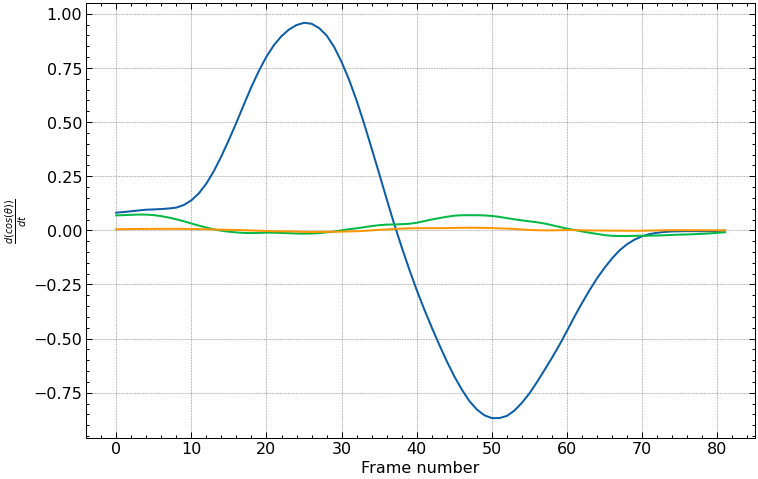

In [124]:
o = np.arange(0,len(ang),1)
plt.figure(figsize=(12,8))
plt.plot(o, Vel[:,2])
plt.plot(o, Vel[:,1])
plt.plot(o, Vel[:,0])
plt.xlabel('Frame number')
plt.ylabel(r'$\frac{d(cos(\theta))}{dt}$', fontsize = 14)

In [125]:
final_data = np.concatenate((ang, ang_vel), axis=1)
# final_data = angles

In [126]:
X = 10
sequences = np.zeros((final_data.shape[0]-X, X, 6))
for i in range(X,final_data.shape[0]):
    sequences[i-X] = final_data[i-X:i]

In [127]:
res = Model.predict(sequences)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [128]:
res_avg = np.copy(res)
Window_Size = 15
res_avg[:,0],res_avg[:,1],res_avg[:,2]= moving_average(res[:,0],Window_Size),moving_average(res[:,1],Window_Size),moving_average(res[:,2],Window_Size)

In [129]:
np.argmax(res_avg,axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0], dtype=int64)

Now I need to figure out at which time the class changes from one to another. This will allow me to pinpoint when exactly the concentric contraction and eccentric contractions begin.

In [130]:
bin_res = to_categorical(np.argmax(res_avg,axis=1),3)
class_change = bin_res[:-1]*bin_res[1:] #this will leave all rows the same except for when a change of class is seen, where it will equal [0,0,0]
change_index = np.where(np.all(class_change==[0,0,0],axis=1))[0] #this returns the index where the class changes

Now figure out which order the classes come in. So the idea is that I will have two arrays, one indicating the order of the classes, and the other containing the frames at which the class changes.

In [131]:
#initiate the array that will contain the class_order
class_order = np.zeros((len(change_index)+1,3))
for i in range(len(change_index)):
    if i == 0:
        class_order[0] = bin_res[change_index[i]]
        class_order[1] = bin_res[change_index[i]+1]
    else:
        class_order[i+1] = bin_res[change_index[i]+1]

#change class_order to numbers rather than vectors where No Curl = 0, Concentric = 1, Eccentric = 2
class_order = np.argmax(class_order,axis=1)

In [132]:
class_order

array([0, 1, 2, 0], dtype=int64)

Now I need to extract the positional path of each concentric and eccentric contraction.

Also, make a normalized time between 0 and 1 for each instance of concentric and eccentric. Making the "time" range between 0 and 1 means that when comparing different contractions, the speed of contractions is irrelevant, only the spatial path.

In [133]:
#initiate two lists that will contain the paths of the angles between each limb combination during concentric and eccentric contraction, respectively.
concentric = []
eccentric = []

#initiate two lists that will contain the time lists for each instance
concentric_time = []
eccentric_time = []

for i in range(len(class_order)-1):
    #Find what the current and next class is
    class1 = class_order[i]
    class2 = class_order[i+1]
    #We only care about concentric and eccentric contraction, therefore if the current class is no curl, then just ignore.
    if class1==0:
        pass
    #Next treat the concentric contraction, extract the relevant angles and append to the concentric list above.
    elif class1 == 1:
        #define the initial and final index of the range of frames that concentric contraction occurs.
        #note that the +10 comes from the fact that a prediction is not made on the first 9 frames of the video due to the sliding window of the GRU
        if i == 0:
            index1 = 10
        else:
            index1 = change_index[i-1]+10
        index2 = change_index[i]+10
        
        #Now extract the relevant angles that make up the current path.
        current_path = Angles[index1:index2]
        
        #Create an array representing the normalised time (between 0 and 1)
        time = np.linspace(0,1,len(current_path))
        
        #append the results
        concentric.append(current_path)
        concentric_time.append(time)
    
    #Now the eccentric contraction
    elif class1 == 2:
        #define the initial and final index of the range of frames that concentric contraction occurs.
        index1 = change_index[i-1]+10
        index2 = change_index[i]+10
        
        #Now extract the relevant angles that make up the current path.
        current_path = Angles[index1:index2]
        
        #Create an array representing the normalised time (between 0 and 1)
        time = np.linspace(0,1,len(current_path))
        
        #append the results
        eccentric.append(current_path)
        eccentric_time.append(time)
        
#Now need to account for the case that we do not finish with a class 0 (rest) i.e we could finish on a concentric or an eccentric
#first consider the case when the video finished on a concentric (class 1)
if class_order[-1] == 1:
    index1 = change_index[-1]+10
    current_path = Angles[index1:]
    time = np.linspace(0,1,len(current_path))
    concentric.append(current_path)
    concentric_time.append(time)
    
#Now consider the case when the video finishes on an eccentric (class 2)
if class_order[-1] == 2:
    index1 = change_index[-1]+10
    current_path = Angles[index1:]
    time = np.linspace(0,1,len(current_path))
    eccentric.append(current_path)
    eccentric_time.append(time)

In [134]:
len(concentric), len(eccentric)

(1, 1)

Each example will not necessarily be of the same length since the speed of the curl will vary. I want the output of the data to be sampled at the exact same normalised times and be of the same lengths. To do this I will use cubic splines to interpolate the data and then sample this spline function.

The reason I want this is because it allows for me to use less data if I want less overfitting, at least that's the plan. Maybe having all datapoints sampled at the same timestamps will not perform well, but for now I will do this. Also, if all sequences are the same length then I can more easily store them, i.e. in an array instead of a list.

In [135]:
def equal_lengths(Data, Time, sequence_length):
    #The data is three dimensional, therefore interpolate each dimension separately.
    X = Data[:,0]
    Y = Data[:,1]
    Z = Data[:,2]
    
    X_interp = InterpolatedUnivariateSpline(Time, X, k=3)
    Y_interp = InterpolatedUnivariateSpline(Time, Y, k=3)
    Z_interp = InterpolatedUnivariateSpline(Time, Z, k=3)
    
    #Now sample the data at time intervals dt then re-combine
    t = np.linspace(0,1,sequence_length)
    x = X_interp(t)
    y = Y_interp(t)
    z = Z_interp(t)
    equal_length_data = np.stack((x,y,z),axis=1)
    
    #Return the data and the normalised time
    return equal_length_data

In [136]:
sequence_length = 15

#now since all the sequences will be the same length we can store them all in a numpy array
equal_concentric = np.zeros((len(concentric), sequence_length, 3))
equal_eccentric = np.zeros((len(eccentric), sequence_length, 3))
#note that we don't need to save the time series since we can easily reproduce it, between zero and 1 with sequence_length amount of points.

#Loop through the concentric, filling in the corresponding array
for i in range(len(concentric)):
    D_con = equal_lengths(concentric[i],concentric_time[i],sequence_length)
    equal_concentric[i] = D_con
    
#Loop through the eccentric, filling in the corresponding array
for i in range(len(eccentric)):
    D_ecc = equal_lengths(eccentric[i],eccentric_time[i],sequence_length)
    equal_eccentric[i] = D_ecc

Now just save the array. Note that there is no need to save the times, since these can easily be reproduced at any time

In [137]:
np.save("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Technique Modelling\\Bicep Curl\\Perfect Technique Modelling\\Training Data\\incorrectConc8.npy", equal_concentric)
np.save("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Technique Modelling\\Bicep Curl\\Perfect Technique Modelling\\Training Data\\incorrectEcc8.npy", equal_eccentric)

The rest of the code is just to plot and visualise the data.

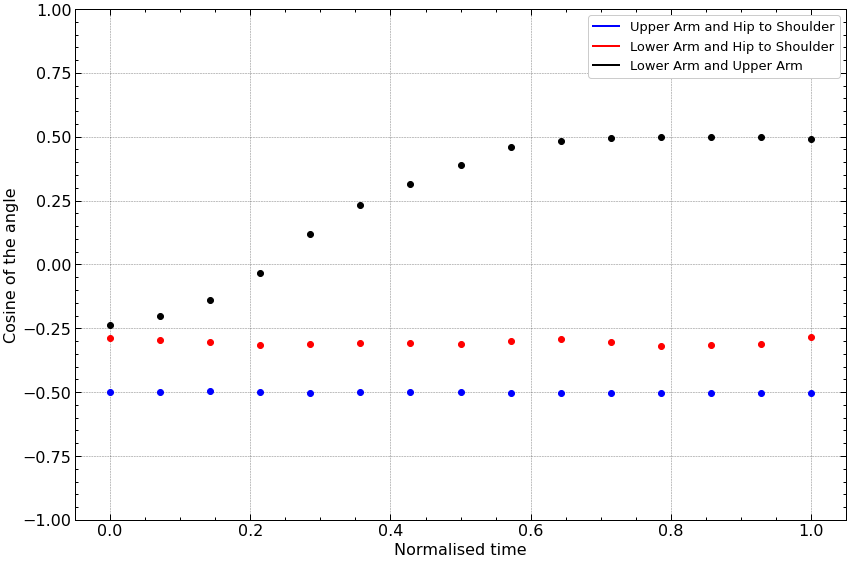

In [138]:
time = np.linspace(0,1,sequence_length)
plt.figure(figsize=(12,8))
for i in range(len(concentric)):
    plt.scatter(time, equal_concentric[i,:,0],c='b')
    plt.scatter(time, equal_concentric[i,:,1],c='r')
    plt.scatter(time, equal_concentric[i,:,2],c='black')
#     plt.scatter(time, equal_eccentric[i,:,0],c='b')
#     plt.scatter(time, equal_eccentric[i,:,1],c='r')
#     plt.scatter(time, equal_eccentric[i,:,2],c='black')
plt.ylabel('Normalised Angle')
plt.xlabel('Normalised time')
labels = ['Torso Angle', 'Upper Arm Angle', 'Lower Arm Angle']
legend_elements = [plt.Line2D([0], [0], color='b', label=labels[0]), plt.Line2D([0], [0], color='r', label=labels[1]), plt.Line2D([0], [0], color='black', label=labels[2])]
plt.ylim(-1,1)

plt.legend(handles=legend_elements,fontsize=13)
plt.tight_layout()
plt.savefig("C:\\Users\\Cian\\Downloads\\FIG1.png")

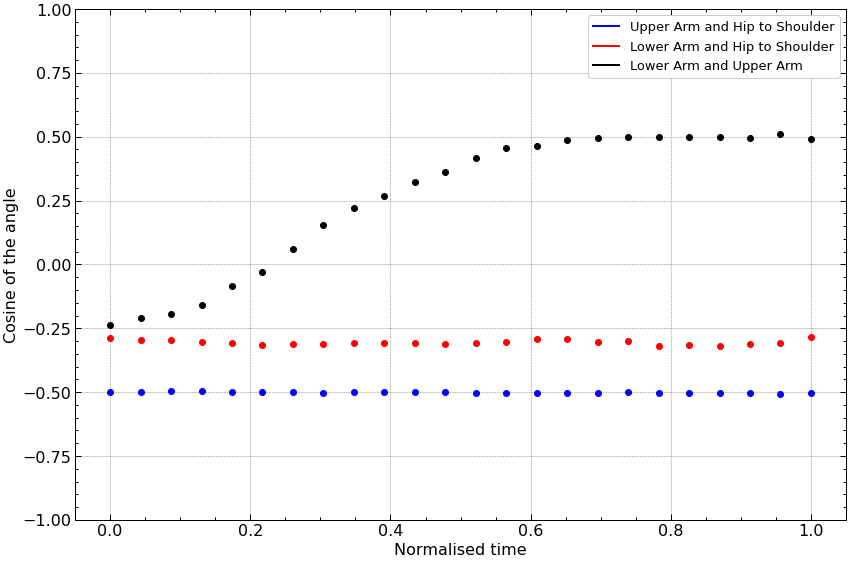

In [139]:
time = np.linspace(0,1,sequence_length)
plt.figure(figsize=(12,8))
for i in range(len(concentric)):
    plt.scatter(concentric_time[i], concentric[i][:,0],c='b')
    plt.scatter(concentric_time[i], concentric[i][:,1],c='r')
    plt.scatter(concentric_time[i], concentric[i][:,2],c='black')
#     plt.scatter(eccentric_time[i], eccentric[i][:,0],c='b')
#     plt.scatter(eccentric_time[i], eccentric[i][:,1],c='r')
#     plt.scatter(eccentric_time[i], eccentric[i][:,2],c='black')
plt.ylabel('Normalised Angle')
plt.xlabel('Normalised time')
labels = ['Torso Angle', 'Upper Arm Angle', 'Lower Arm Angle']
legend_elements = [plt.Line2D([0], [0], color='b', label=labels[0]), plt.Line2D([0], [0], color='r', label=labels[1]), plt.Line2D([0], [0], color='black', label=labels[2])]
plt.ylim(-1,1)

plt.legend(handles=legend_elements,fontsize=13)
plt.tight_layout()
plt.savefig("C:\\Users\\Cian\\Downloads\\FIG2.png")